--- Start training model with RandomForest - ML model ---
[1/6] Successfully loading 'npm_shuffled.csv' with 8984 sample.
[2/6] Number of features: 16.
[3/6] Successfully splitting: 7187 training samples, 1797 evaluating ssamples.
[4/6] Finish standardization with StandardScaler.
[-] Saving the fitted scaler to 'scaler.joblib'...
Scaler has been saved successfully.
[5/6] Starting model training with Random Forest...
Finish training!

Saving trained model to 'trained_model/random_forest_model.joblib'...
Model has been saved successfully.
[6/6] Evaluating...

================== EVALUATION RESULT ==================
Accuracy: 0.9872 (98.72%)

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98       600
   Malicious       0.98      1.00      0.99      1197

    accuracy                           0.99      1797
   macro avg       0.99      0.98      0.99      1797
weighted avg       0.99      0.99      0.99      1797


Me

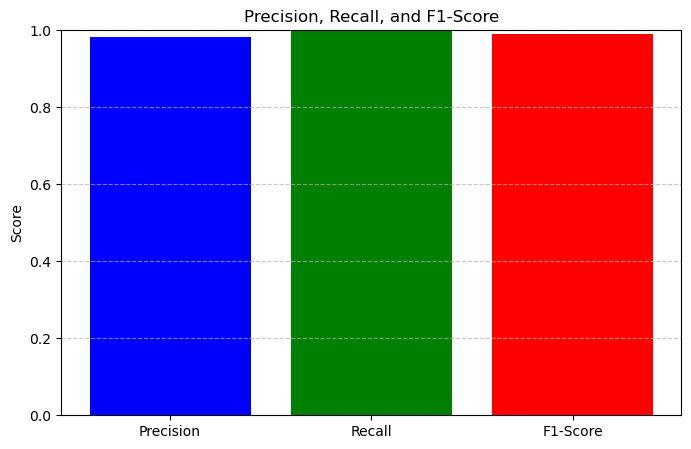


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

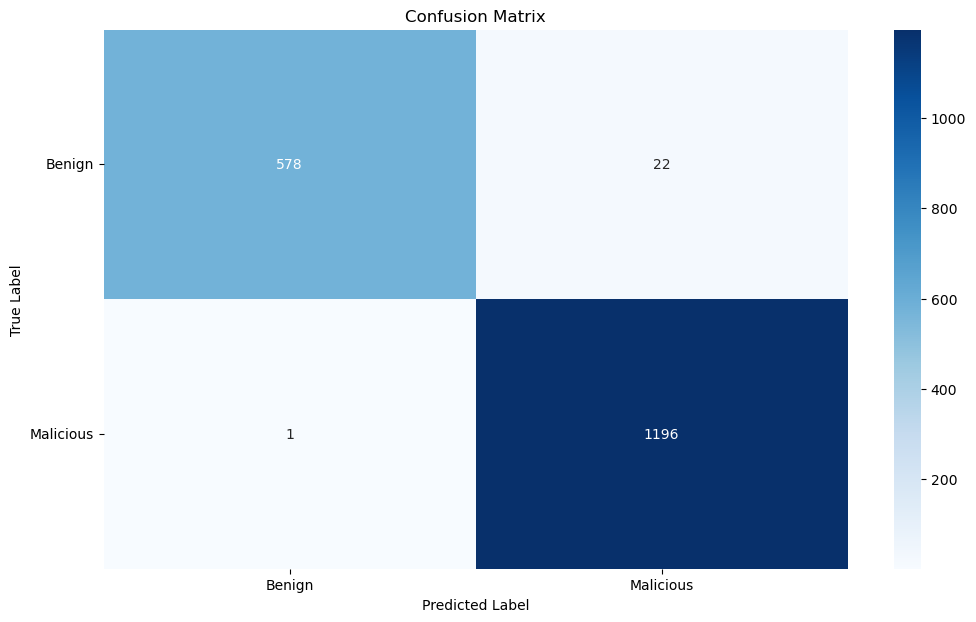

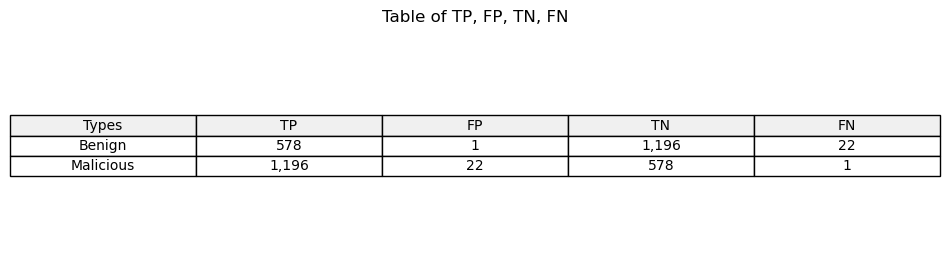

/tmp/ipykernel_396/1022758677.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)


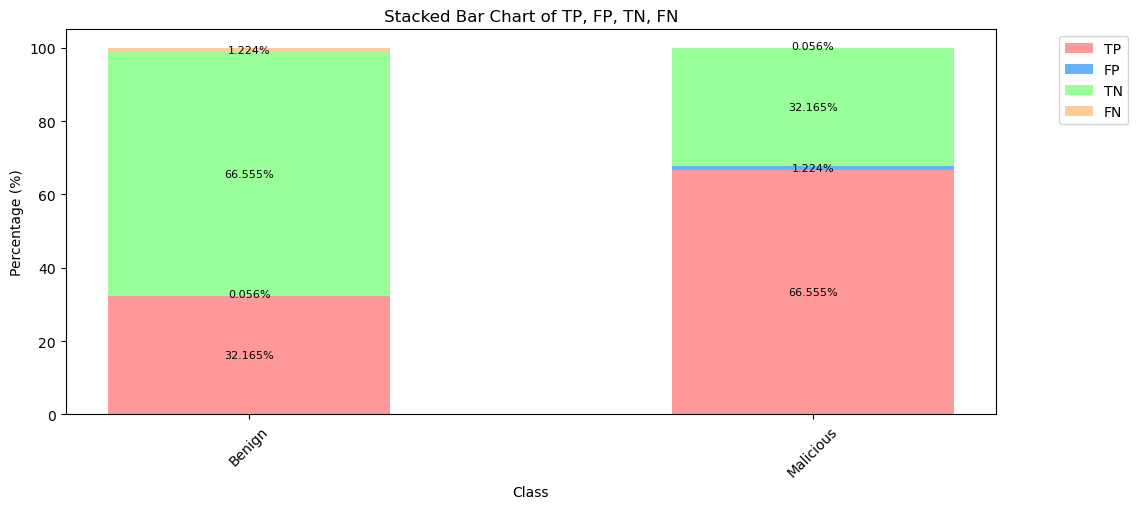



Top 10 of the most important features:
has_dev_dependencies    0.290777
num_dev_dependencies    0.211414
has_dependencies        0.160443
num_dependencies        0.127583
total_code_size         0.095619
num_files               0.059465
max_entropy             0.021827
avg_entropy             0.017894
num_urls                0.008586
num_ips                 0.005653
dtype: float64


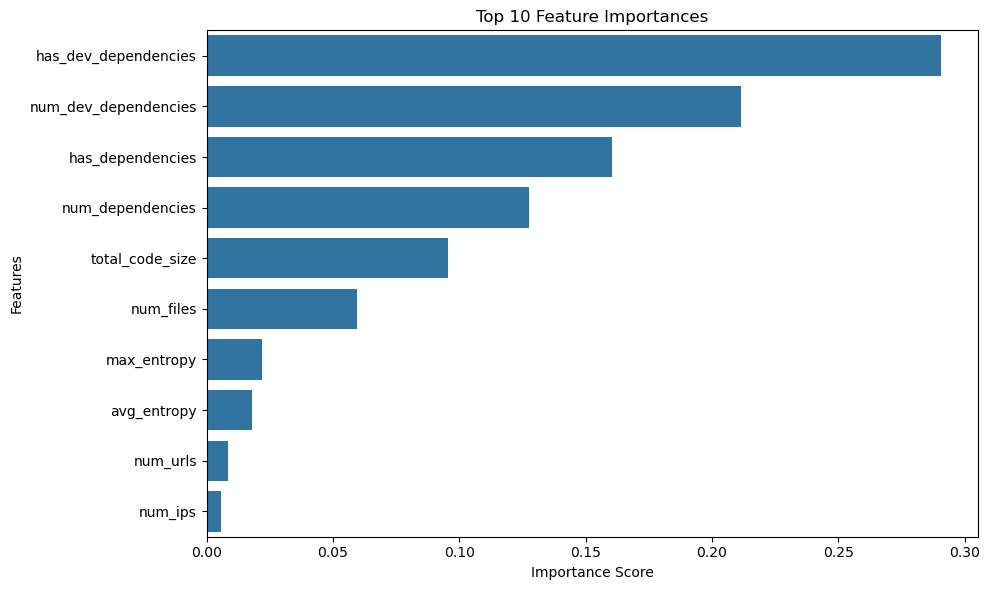

In [1]:
# random_forest
import pandas as pd
from datetime import datetime, timedelta
import sys, os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

tempdir_evaluation = 'evaluation_result'
tempdir_model = 'trained_model'
INPUT_FILE = 'npm_shuffled.csv'
SAVED_MODEL_PATH = tempdir_model + '/random_forest_model.joblib'

def train_and_evaluate(input_file):

    print(f"--- Start training model with RandomForest - ML model ---")

    try:
        df = pd.read_csv(input_file)
        print(f"[1/6] Successfully loading '{input_file}' with {len(df)} sample.")
    except FileNotFoundError:
        print(f"Error: Cannot find this file '{input_file}'.")
        return

    X = df.drop(columns=['label', 'package_name'])
    y = df['label']

    feature_names = X.columns
    print(f"[2/6] Number of features: {X.shape[1]}.")

    # Splitting dataset into two parts for training and evaluating
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"[3/6] Successfully splitting: {len(X_train)} training samples, {len(X_test)} evaluating ssamples.")

    # Feature Scaling/Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("[4/6] Finish standardization with StandardScaler.")
    
    print("[-] Saving the fitted scaler to 'scaler.joblib'...")
    joblib.dump(scaler, 'scaler/scaler.joblib')
    print("Scaler has been saved successfully.")

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

    print("[5/6] Starting model training with Random Forest...")
    model.fit(X_train_scaled, y_train)
    print("Finish training!")

    print(f"\nSaving trained model to '{SAVED_MODEL_PATH}'...")
    joblib.dump(model, SAVED_MODEL_PATH)
    print(f"Model has been saved successfully.")
    
    print("[6/6] Evaluating...")
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("\n================== EVALUATION RESULT ==================")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(report)
    print("\nMetrics (Precision, Recall, F1-Score):")
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)
    
    param_names = ['Precision', 'Recall', 'F1-Score']
    array = [precision, recall, f1]
    
    x = np.arange(len(param_names))
    width = 0.2  # Độ rộng của mỗi cột
    plt.figure(figsize=(8, 5))
    plt.bar(param_names, array, color=['blue', 'green', 'red'])
    
    # Cấu hình trục và nhãn
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score")
    plt.ylim(0, 1)  # Giá trị từ 0 đến 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()
    plt.savefig(tempdir_evaluation + "/evaluation_metrics_random_forest.png", dpi=300, bbox_inches="tight")

    
    print("\nConfusion Matrix:")
    attack_types = ['Benign', 'Malicious']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(tempdir_evaluation+ "/confusion_matrix_random_forest.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Tính và vẽ TP, FP, TN, FN
    metrics = []
    num_classes = len(attack_types)
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])
    
    df_metrics = pd.DataFrame(metrics, columns=["Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title("Table of TP, FP, TN, FN")
    plt.savefig(tempdir_evaluation + "/table_tp_fp_tn_fn_random_forest.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]
    
    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]
    
    ax.set_xlabel("Class", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_title("Stacked Bar Chart of TP, FP, TN, FN", fontsize=12)
    ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)
    ax.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.15, 1))
    plt.savefig(tempdir_evaluation + "/stacked_bar_chart_tp_fp_tn_fn_random_forest.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("\n=======================================================")

    
    # --- (Tùy chọn) Hiển thị độ quan trọng của các đặc tính ---
    print("\nTop 10 of the most important features:")
    feature_importances = pd.Series(model.feature_importances_, index=feature_names).nlargest(10)
    print(feature_importances)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(tempdir_evaluation + '/feature_importances_random_forest.png')



if __name__ == '__main__':
    train_and_evaluate(INPUT_FILE)

--- Training model with Support Vector Machine (SVM) ---
[1/3] Finish loading and scaling data.
[2/3] Start training model with SVM...
Finish training!

Saving trained model to 'trained_model/svm_model.joblib'...
Model has been saved successfully.
[3/3] Evaluating...

================== EVALUATION RESULT ==================
Accuracy: 0.9861 (98.61%)

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98       600
   Malicious       0.98      1.00      0.99      1197

    accuracy                           0.99      1797
   macro avg       0.99      0.98      0.98      1797
weighted avg       0.99      0.99      0.99      1797


Metrics (Precision, Recall, F1-Score):
Precision:  0.9795417348608838
Recall:  1.0
F1-Score:  0.989665150888797


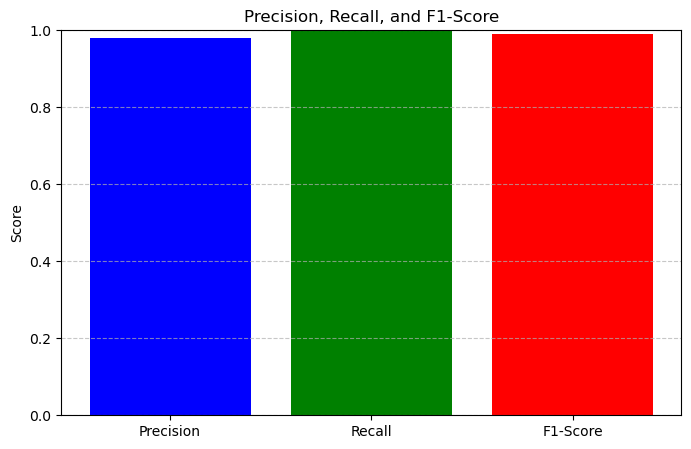


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

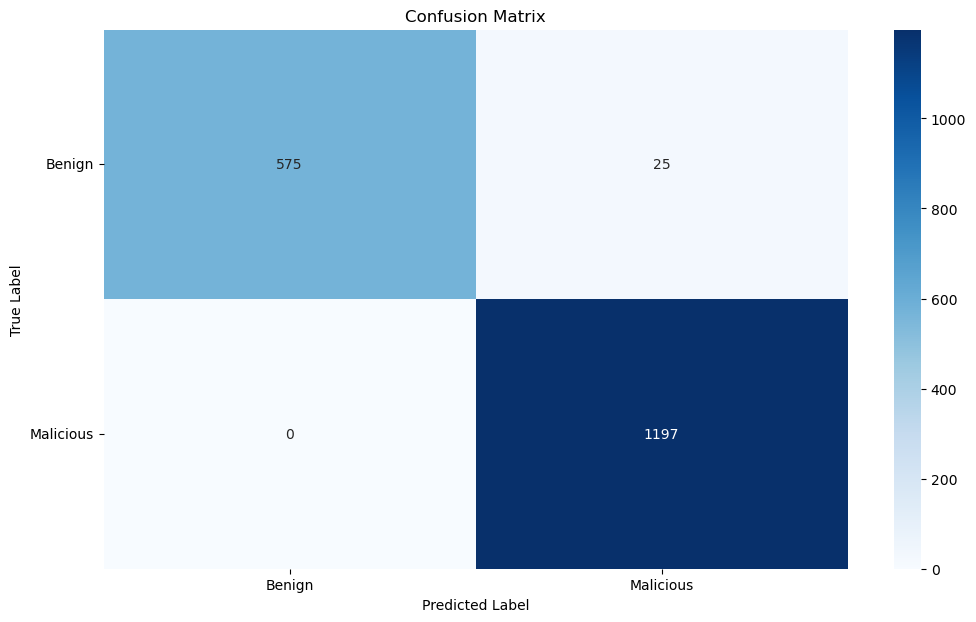

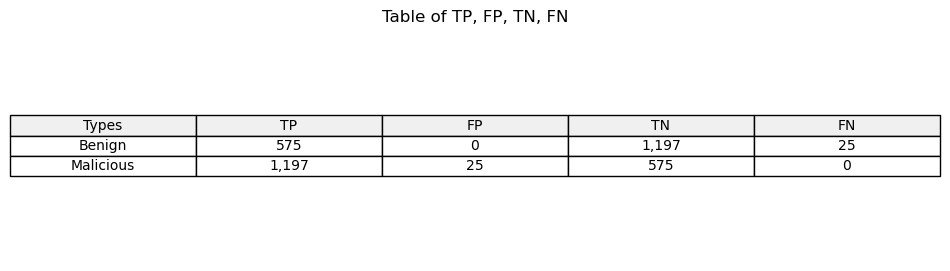

/tmp/ipykernel_57297/824277942.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)


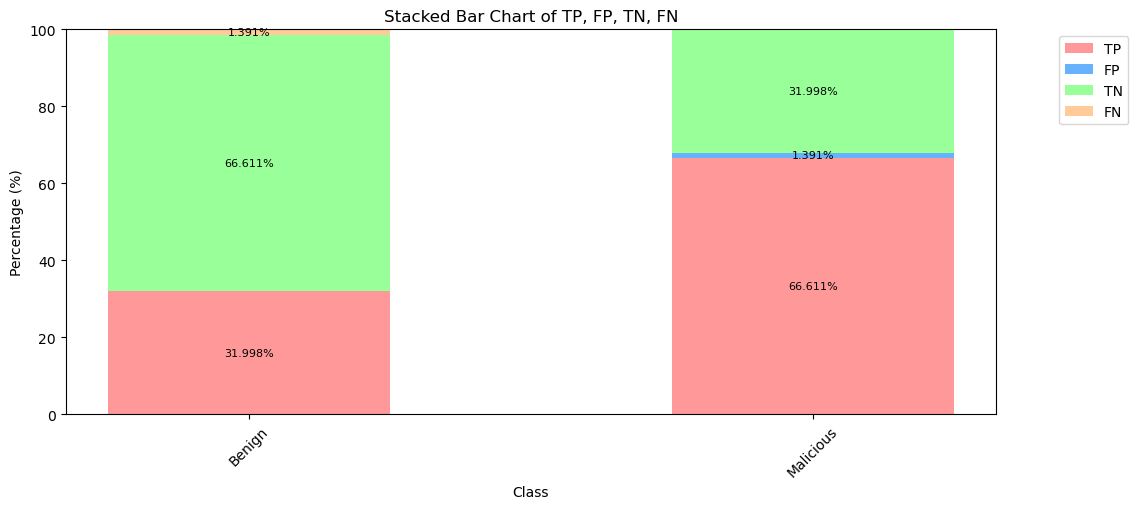

In [2]:
# train_svm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


INPUT_FILE = 'npm_shuffled.csv'

def train_svm_model(input_file):
    print(f"--- Training model with Support Vector Machine (SVM) ---")
    
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: Cannot find this file '{input_file}'.")
        return

    X = df.drop(columns=['label', 'package_name'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"[1/3] Finish loading and scaling data.")


    model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
    print("[2/3] Start training model with SVM...")
    model.fit(X_train_scaled, y_train)
    print("Finish training!")
    
    SAVED_MODEL_PATH = tempdir_model + '/svm_model.joblib'
    print(f"\nSaving trained model to '{SAVED_MODEL_PATH}'...")
    joblib.dump(model, SAVED_MODEL_PATH)
    print(f"Model has been saved successfully.")
    
    print("[3/3] Evaluating...")
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])

    print("\n================== EVALUATION RESULT ==================")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(report)
    print("\nMetrics (Precision, Recall, F1-Score):")
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)
    
    param_names = ['Precision', 'Recall', 'F1-Score']
    array = [precision, recall, f1]
    
    x = np.arange(len(param_names))
    width = 0.2  # Độ rộng của mỗi cột
    plt.figure(figsize=(8, 5))
    plt.bar(param_names, array, color=['blue', 'green', 'red'])
    
    # Cấu hình trục và nhãn
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score")
    plt.ylim(0, 1)  # Giá trị từ 0 đến 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()
    plt.savefig(tempdir_evaluation + "/evaluation_metrics_svm.png", dpi=300, bbox_inches="tight")

    print("\nConfusion Matrix:")
    attack_types = ['Benign', 'Malicious']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(tempdir_evaluation + "/confusion_matrix_svm.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Tính và vẽ TP, FP, TN, FN
    metrics = []
    num_classes = len(attack_types)
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])
    
    df_metrics = pd.DataFrame(metrics, columns=["Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title("Table of TP, FP, TN, FN")
    plt.savefig(tempdir_evaluation + "/table_tp_fp_tn_fn_svm.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]
    
    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]
    
    ax.set_xlabel("Class", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_title("Stacked Bar Chart of TP, FP, TN, FN", fontsize=12)
    ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)
    ax.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.15, 1))
    plt.savefig(tempdir_evaluation + "/stacked_bar_chart_tp_fp_tn_fn_svm.png", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == '__main__':
    train_svm_model(INPUT_FILE)

--- Training model with LightGBM ---
[1/3] Finish loading and scaling data.
[2/3] Start training with LightGBM...
[LightGBM] [Info] Number of positive: 4788, number of negative: 2399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 7187, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666203 -> initscore=0.691061
[LightGBM] [Info] Start training from score 0.691061
Finish training!

Saving trained model to 'trained_model/light_gbm_model.joblib'...
Model has been saved successfully.
[3/3] Evaluating...

================== EVALUATION RESULT ==================
Accuracy: 0.9866 (98.66%)

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.9

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


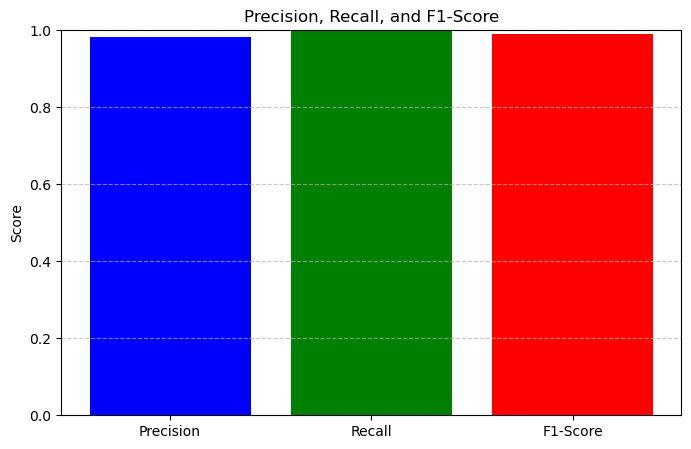


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

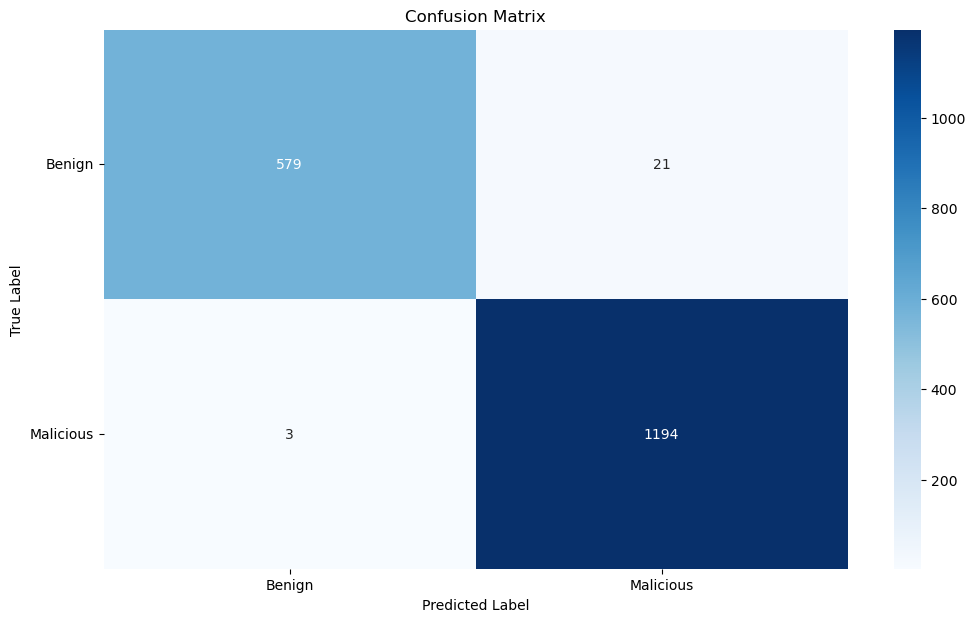

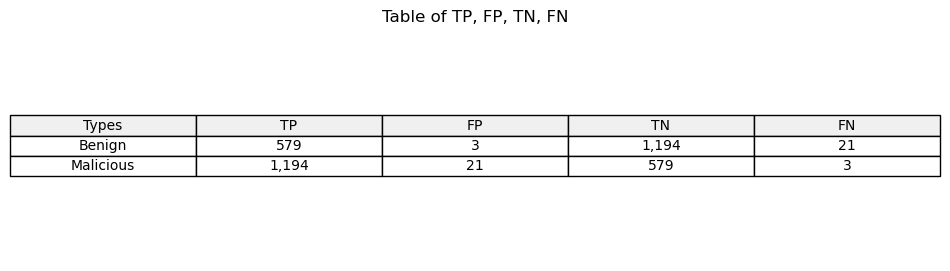

/tmp/ipykernel_57297/4073437618.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)


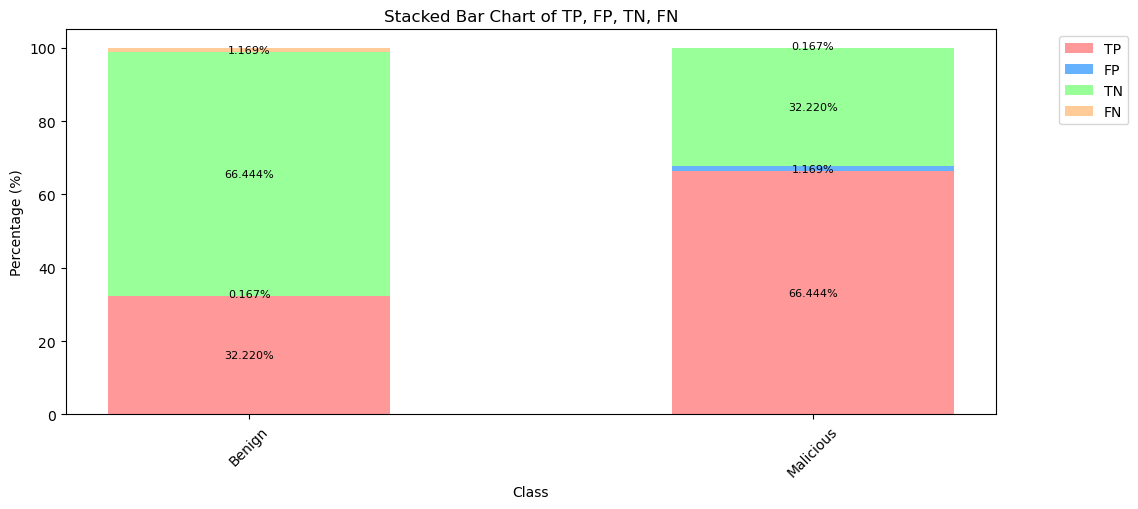

In [3]:
# train_lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Cấu hình ---
INPUT_FILE = 'npm_shuffled.csv'

def train_lgbm_model(input_file):
    print(f"--- Training model with LightGBM ---")

    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: Cannot find this file '{input_file}'.")
        return

    X = df.drop(columns=['label', 'package_name'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"[1/3] Finish loading and scaling data.")

    # objective='binary' cho bài toán phân loại nhị phân.
    model = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)
    print("[2/3] Start training with LightGBM...")
    model.fit(X_train_scaled, y_train)
    print("Finish training!")

    SAVED_MODEL_PATH = tempdir_model + '/light_gbm_model.joblib'
    print(f"\nSaving trained model to '{SAVED_MODEL_PATH}'...")
    joblib.dump(model, SAVED_MODEL_PATH)
    print(f"Model has been saved successfully.")
    
    print("[3/3] Evaluating...")
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])

    print("\n================== EVALUATION RESULT ==================")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(report)
    print("\nMetrics (Precision, Recall, F1-Score):")
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)
    
    param_names = ['Precision', 'Recall', 'F1-Score']
    array = [precision, recall, f1]
    
    x = np.arange(len(param_names))
    width = 0.2  # Độ rộng của mỗi cột
    plt.figure(figsize=(8, 5))
    plt.bar(param_names, array, color=['blue', 'green', 'red'])
    
    # Cấu hình trục và nhãn
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score")
    plt.ylim(0, 1)  # Giá trị từ 0 đến 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()
    plt.savefig(tempdir_evaluation + "/evaluation_metrics_light_gbm.png", dpi=300, bbox_inches="tight")
    
    print("\nConfusion Matrix:")
    attack_types = ['Benign', 'Malicious']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(tempdir_evaluation + "/confusion_matrix_light_gbm.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Tính và vẽ TP, FP, TN, FN
    metrics = []
    num_classes = len(attack_types)
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])
    
    df_metrics = pd.DataFrame(metrics, columns=["Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title("Table of TP, FP, TN, FN")
    plt.savefig(tempdir_evaluation + "/table_tp_fp_tn_fn_light_gbm.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]
    
    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]
    
    ax.set_xlabel("Class", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_title("Stacked Bar Chart of TP, FP, TN, FN", fontsize=12)
    ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)
    ax.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.15, 1))
    plt.savefig(tempdir_evaluation + "/stacked_bar_chart_tp_fp_tn_fn_light_gbm.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == '__main__':
    train_lgbm_model(INPUT_FILE)

--- Training model with K-Nearest Neighbors (KNN) ---
Finish training!

Saving trained model to 'trained_model/knn_model.joblib'...
Model has been saved successfully.

================== EVALUATION RESULT (KNN, k=5) ==================
Accuracy: 0.9866 (98.66%)

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98       600
   Malicious       0.98      1.00      0.99      1197

    accuracy                           0.99      1797
   macro avg       0.99      0.98      0.98      1797
weighted avg       0.99      0.99      0.99      1797


Metrics (Precision, Recall, F1-Score):
Precision:  0.9803439803439803
Recall:  1.0
F1-Score:  0.9900744416873449


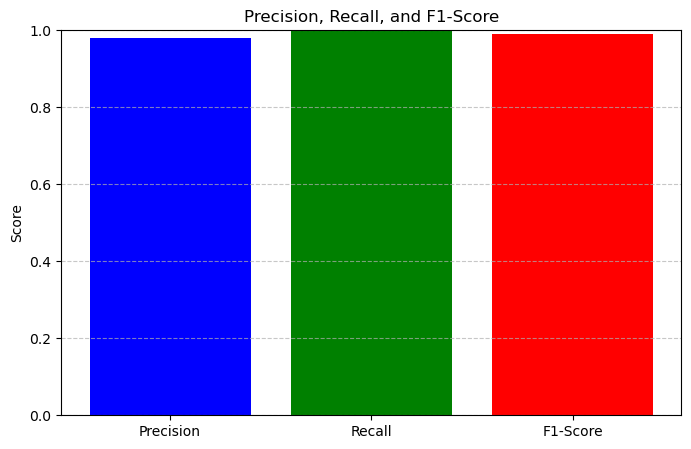


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

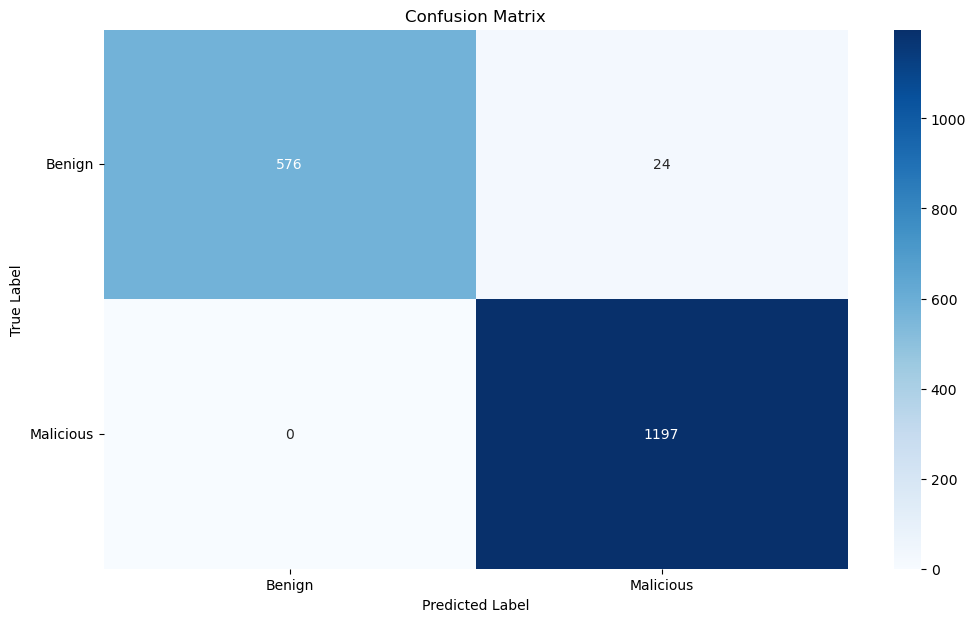

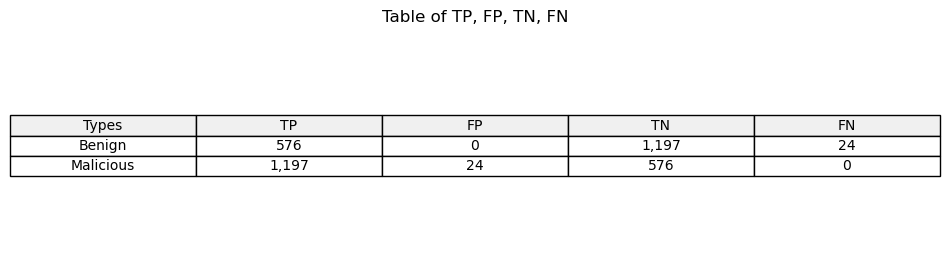

/tmp/ipykernel_57297/2664660419.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)


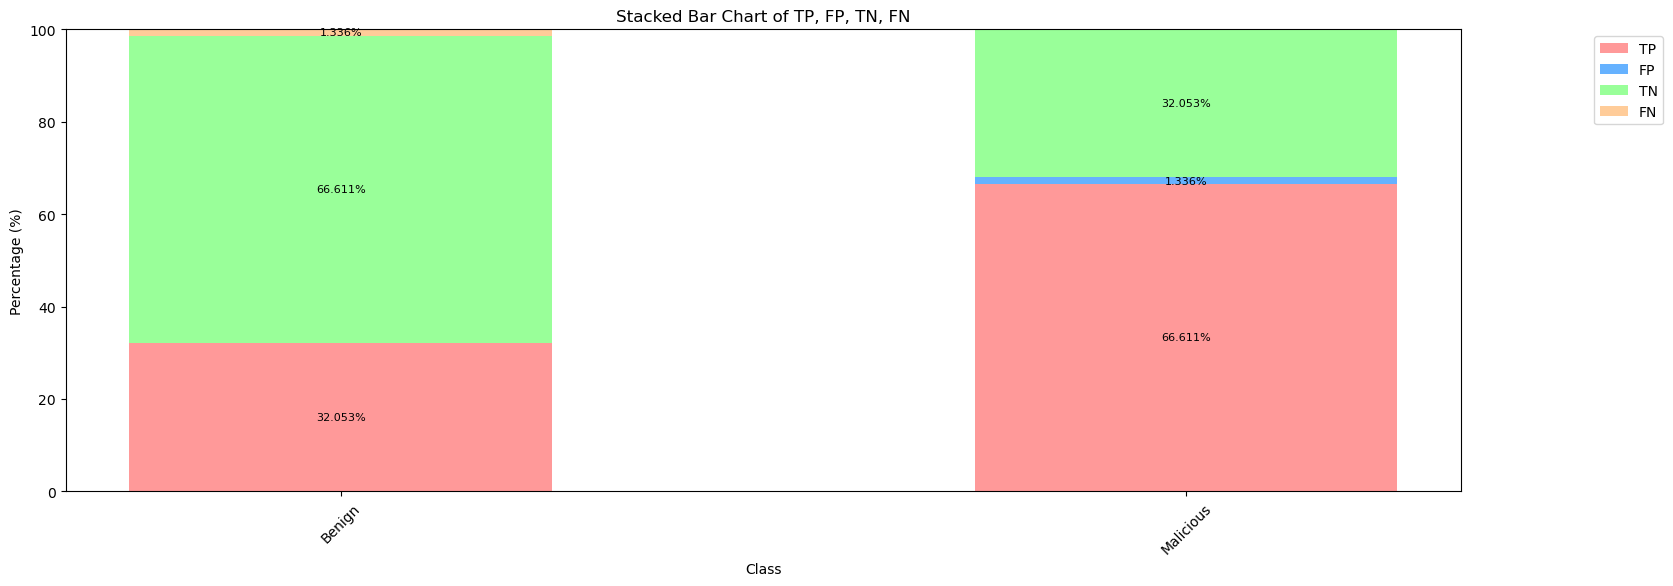

In [4]:
# train_knn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
# --- Cấu hình ---
INPUT_FILE = 'npm_shuffled.csv'
N_NEIGHBORS = 5 # Số 'hàng xóm' cần xem xét

def train_knn_model(input_file):
    print(f"--- Training model with K-Nearest Neighbors (KNN) ---")
    
    # Bước 1: Tải và chuẩn bị dữ liệu
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: Cannot find this file '{input_file}'.")
        return

    X = df.drop(columns=['label', 'package_name'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = KNeighborsClassifier(n_neighbors=N_NEIGHBORS, weights='distance', n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    print("Finish training!")

    SAVED_MODEL_PATH = tempdir_model + '/knn_model.joblib'
    print(f"\nSaving trained model to '{SAVED_MODEL_PATH}'...")
    joblib.dump(model, SAVED_MODEL_PATH)
    print(f"Model has been saved successfully.")
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])

    print(f"\n================== EVALUATION RESULT (KNN, k={N_NEIGHBORS}) ==================")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(report)
    print("\nMetrics (Precision, Recall, F1-Score):")
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)
    
    param_names = ['Precision', 'Recall', 'F1-Score']
    array = [precision, recall, f1]
    
    x = np.arange(len(param_names))
    width = 0.2  # Độ rộng của mỗi cột
    plt.figure(figsize=(8, 5))
    plt.bar(param_names, array, color=['blue', 'green', 'red'])
    
    # Cấu hình trục và nhãn
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score")
    plt.ylim(0, 1)  # Giá trị từ 0 đến 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()
    plt.savefig(tempdir_evaluation + "/evaluation_metrics_knn.png", dpi=300, bbox_inches="tight")
    
    print("\nConfusion Matrix:")
    attack_types = ['Benign', 'Malicious']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(tempdir_evaluation + "/confusion_matrix_knn.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Tính và vẽ TP, FP, TN, FN
    metrics = []
    num_classes = len(attack_types)
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])
    
    df_metrics = pd.DataFrame(metrics, columns=["Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title("Table of TP, FP, TN, FN")
    #plt.tight_layout(pad=0.5)
    plt.savefig(tempdir_evaluation + "/table_tp_fp_tn_fn_knn.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100
    
    fig, ax = plt.subplots(figsize=(18, 6))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]
    
    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]
    
    ax.set_xlabel("Class", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_title("Stacked Bar Chart of TP, FP, TN, FN", fontsize=12)
    ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)
    ax.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.15, 1))
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdir_evaluation + "/stacked_bar_chart_tp_fp_tn_fn_knn.png", dpi=300, bbox_inches="tight")
    plt.show()
if __name__ == '__main__':
    train_knn_model(INPUT_FILE)

--- Training model with Logistic Regression ---
Finish training!

Saving trained model to 'trained_model/log_reg_model.joblib'...
Model has been saved successfully.

================== EVALUATION RESULT ==================
Accuracy: 0.9861 (98.61%)

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98       600
   Malicious       0.98      1.00      0.99      1197

    accuracy                           0.99      1797
   macro avg       0.99      0.98      0.98      1797
weighted avg       0.99      0.99      0.99      1797


Metrics (Precision, Recall, F1-Score):
Precision:  0.9795417348608838
Recall:  1.0
F1-Score:  0.989665150888797


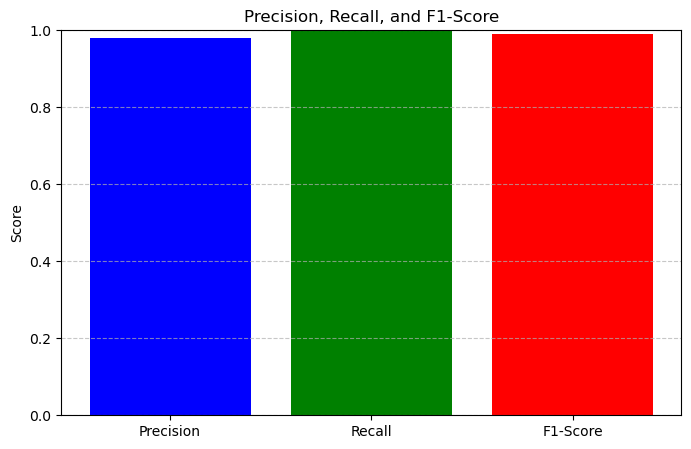


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

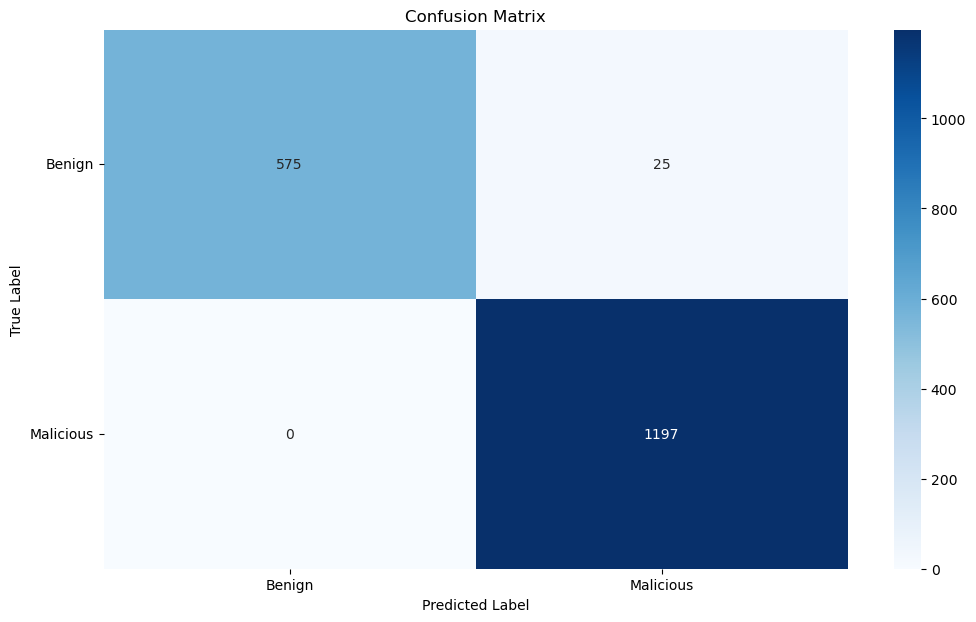

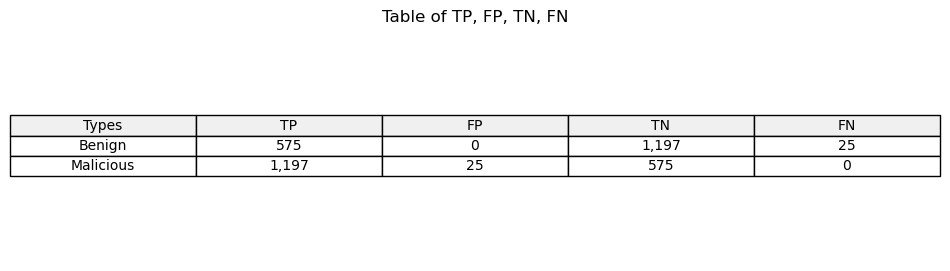

/tmp/ipykernel_57297/2106331110.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)


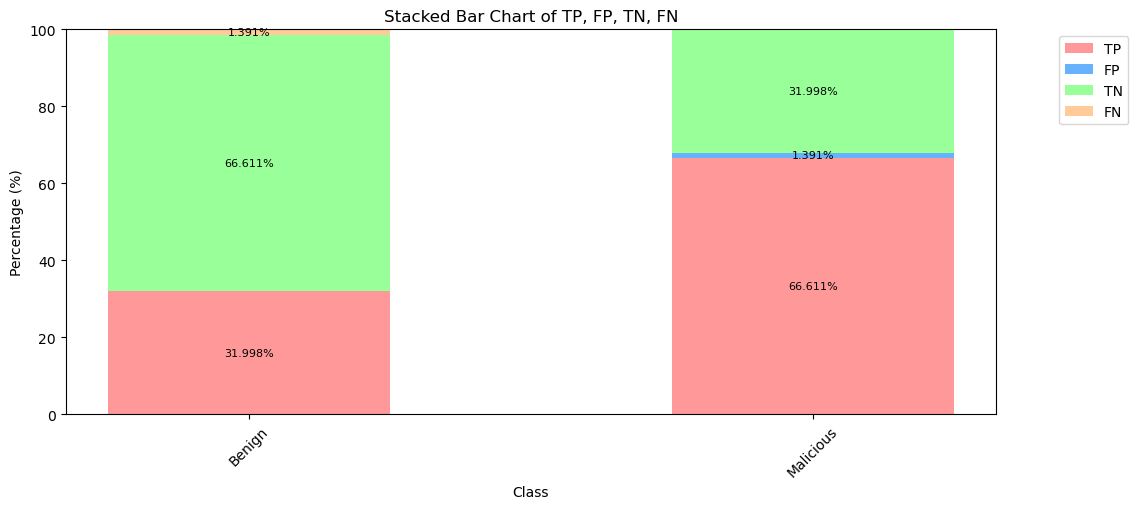

In [5]:
# train_logreg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

INPUT_FILE = 'npm_shuffled.csv'

def train_logreg_model(input_file):
    print(f"--- Training model with Logistic Regression ---")
    
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: Cannot find this file '{input_file}'.")
        return

    X = df.drop(columns=['label', 'package_name'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
    model.fit(X_train_scaled, y_train)
    print("Finish training!")

    SAVED_MODEL_PATH = tempdir_model + '/log_reg_model.joblib'
    print(f"\nSaving trained model to '{SAVED_MODEL_PATH}'...")
    joblib.dump(model, SAVED_MODEL_PATH)
    print(f"Model has been saved successfully.")
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])

    print("\n================== EVALUATION RESULT ==================")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nClassification Report:")
    print(report)
    print("\nMetrics (Precision, Recall, F1-Score):")
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)
    
    param_names = ['Precision', 'Recall', 'F1-Score']
    array = [precision, recall, f1]
    
    x = np.arange(len(param_names))
    width = 0.2  # Độ rộng của mỗi cột
    plt.figure(figsize=(8, 5))
    plt.bar(param_names, array, color=['blue', 'green', 'red'])
    
    # Cấu hình trục và nhãn
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score")
    plt.ylim(0, 1)  # Giá trị từ 0 đến 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()
    plt.savefig(tempdir_evaluation + "/evaluation_metrics_log_reg.png", dpi=300, bbox_inches="tight")
    
    print("\nConfusion Matrix:")
    attack_types = ['Benign', 'Malicious']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(tempdir_evaluation + "/confusion_matrix_log_reg.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Tính và vẽ TP, FP, TN, FN
    metrics = []
    num_classes = len(attack_types)
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])
    
    df_metrics = pd.DataFrame(metrics, columns=["Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title("Table of TP, FP, TN, FN")
    plt.savefig(tempdir_evaluation + "/table_tp_fp_tn_fn_log_reg.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]
    
    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]
    
    ax.set_xlabel("Class", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_title("Stacked Bar Chart of TP, FP, TN, FN", fontsize=12)
    ax.set_xticklabels(df_metrics["Types"], rotation=45, fontsize=10)
    ax.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.15, 1))
    plt.savefig(tempdir_evaluation + "/stacked_bar_chart_tp_fp_tn_fn_log_reg.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == '__main__':
    train_logreg_model(INPUT_FILE)